##Importar librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import NearMiss
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold

##importar data set de uno ya previamente tratado


In [11]:

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TelecomX_Data_limpiaV3.csv')

In [12]:
df.head()

,Churn,Genero,Tercera_Edad,Con_Pareja,Tiene_Dependientes,Meses_Contrato,Tiene_Servicio_Telefonico,Servicio_Internet,Tiene_Soporte_Tecnico,Tiene_Streaming_TV,Duración_Contrato,Forma de pago,Cargos_Mensuales,Total_Facturado,Cargos_Diarios
0,0,Female,0,1,1,9,1,DSL,1,1,One year,Mailed check,65.6,593.30,2.186667
1,0,Male,0,0,0,9,1,DSL,0,0,Month-to-month,Mailed check,59.9,542.40,1.996667
2,1,Male,0,0,0,4,1,Fiber optic,0,0,Month-to-month,Electronic check,73.9,280.85,2.463333
3,1,Male,1,1,0,13,1,Fiber optic,0,1,Month-to-month,Electronic check,98.0,1237.85,3.266667
4,1,Female,1,1,0,3,1,Fiber optic,1,1,Month-to-month,Mailed check,83.9,267.40,2.796667


In [13]:
Variables_Categoricas = df.select_dtypes(include=['object']).columns.tolist()

In [14]:
Variables_Categoricas

['Genero',
 'Servicio_Internet',
 'Tiene_Soporte_Tecnico',
 'Duración_Contrato',
 'Forma de pago']

## Encoding

In [15]:
encoder = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore'
)

Array_codificado = encoder.fit_transform(df[Variables_Categoricas])
Variables_categoricas_codificadas = encoder.get_feature_names_out(Variables_Categoricas)
df_x_codificada = pd.DataFrame(Array_codificado, columns=Variables_categoricas_codificadas, index=df.index)
variables_numericas = df.drop(columns=Variables_Categoricas)
Df_final = pd.concat([variables_numericas, df_x_codificada], axis=1)

In [16]:
encoder

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

## Dividir base entre entrenamiento y prueba

In [18]:
X = Df_final.drop(columns=['Churn'])
y = Df_final['Churn']

# Split
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, test_index in kf.split(X):
    print(f"\n--- Fold {fold} ---")

    # Split de data
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    print(f"Training tamaño: {X_train_fold.shape[0]}, Test tamaño: {X_test_fold.shape[0]}")
    fold += 1


--- Fold 1 ---
Training tamaño: 5813, Test tamaño: 1454

--- Fold 2 ---
Training tamaño: 5813, Test tamaño: 1454

--- Fold 3 ---
Training tamaño: 5814, Test tamaño: 1453

--- Fold 4 ---
Training tamaño: 5814, Test tamaño: 1453

--- Fold 5 ---
Training tamaño: 5814, Test tamaño: 1453


## Balanceo de clases

In [19]:
# Combine train features and labels
train_combined = pd.concat([X_train_fold, y_train_fold], axis=1)

# Split by class
train_majority = train_combined[train_combined.Churn == 0]
train_minority = train_combined[train_combined.Churn == 1]

# Downsample majority
train_majority_downsampled = resample(
    train_majority,
    replace=False,
    n_samples=len(train_minority),
    random_state=42
)

# Combine balanced train set
train_balanced = pd.concat([train_majority_downsampled, train_minority])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate X and y again
X_train_bal = train_balanced.drop(columns=['Churn'])
y_train_bal = train_balanced['Churn']

In [20]:
print("Before Undersample:", Counter(y_train_fold))
print("After Undersample:", Counter(y_train_bal))

Before Undersample: Counter({0: 4312, 1: 1502})
After Undersample: Counter({0: 1502, 1: 1502})


In [21]:
# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply to training set
X_train_Oversample, y_train_Oversample = smote.fit_resample(X_train_fold, y_train_fold)

## Modelo Regresión

In [22]:
nm = NearMiss(version=3)
X_train_nm, y_train_nm = nm.fit_resample(X_train_fold, y_train_fold)

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_nm, y_train_nm)
y_pred = knn_model.predict(X_test_fold)

In [23]:
# Accuracy
accuracy = accuracy_score(y_test_fold, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report
print("Classification Report:")
print(classification_report(y_test_fold, y_pred))

# Matriz de Confusión
print("Confusion Matrix:")
print(confusion_matrix(y_test_fold, y_pred))

Accuracy: 0.7089
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1086
           1       0.44      0.60      0.51       367

    accuracy                           0.71      1453
   macro avg       0.65      0.67      0.65      1453
weighted avg       0.75      0.71      0.72      1453

Confusion Matrix:
[[809 277]
 [146 221]]


### Pipeline con el objeto derefinar resultados

In [24]:
knn_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10))
])

knn_pipeline.fit(X_train_nm, y_train_nm)
y_pred = knn_pipeline.predict(X_test_fold)

print(f'Accuracy: {accuracy_score(y_test_fold, y_pred):.4f}')
print(classification_report(y_test_fold, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_fold, y_pred))

Accuracy: 0.7302
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1086
           1       0.48      0.65      0.55       367

    accuracy                           0.73      1453
   macro avg       0.67      0.70      0.68      1453
weighted avg       0.77      0.73      0.74      1453

Confusion Matrix:
[[822 264]
 [128 239]]


### ROC y AUC  evaluación del modelo.

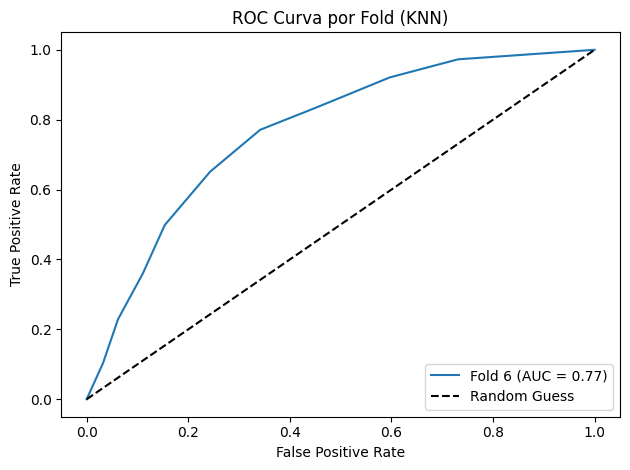

In [27]:
auc_scores = []
y_prueba = knn_pipeline.predict_proba(X_test_fold)[:, 1]

# Calcular AUC
auc = roc_auc_score(y_test_fold, y_prueba)

# Datos para curva ROC
fpr, tpr, _ = roc_curve(y_test_fold, y_prueba)

# Visualización
plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curva por Fold (KNN)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Armar el arbol de decisión

In [28]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
rf_model.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_model.predict(X_test_fold)

### Scoring

In [29]:
# Accuracy
print(f'Accuracy: {accuracy_score(y_test_fold, y_pred_rf):.4f}')

# Classification report
print("Classification Report:")
print(classification_report(y_test_fold, y_pred_rf))

# Matriz de Confusión
print("Confusion Matrix:")
print(confusion_matrix(y_test_fold, y_pred_rf))

Accuracy: 0.7543
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1086
           1       0.51      0.83      0.63       367

    accuracy                           0.75      1453
   macro avg       0.72      0.78      0.72      1453
weighted avg       0.82      0.75      0.77      1453

Confusion Matrix:
[[791 295]
 [ 62 305]]


## Matriz de Confusión


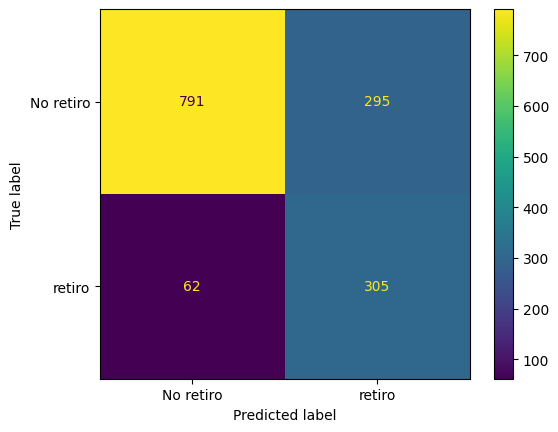

In [30]:
matriz_confusion = confusion_matrix(y_test_fold, y_pred_rf)
visualizacion = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion, display_labels=['No retiro', 'retiro'])
visualizacion.plot();

### Importancia Caractersticas (feature) para afinar el modelo.

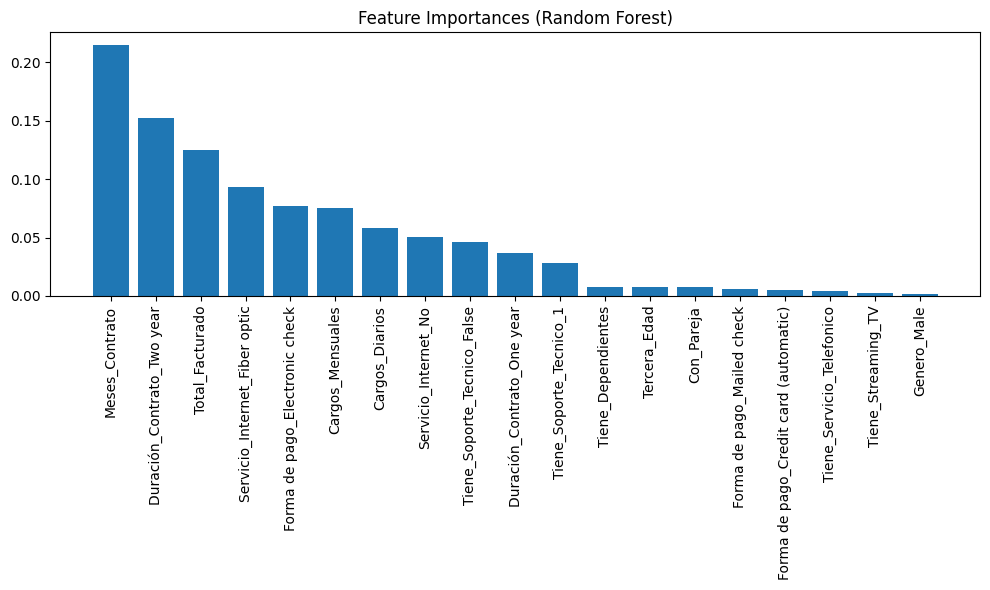

In [32]:
# Importancias
importances = rf_model.feature_importances_
feature_names = X_train_fold.columns

# Ordenar por importancia
indices = np.argsort(importances)[::-1]

# Gráfica
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

##Determinar, entrenar el modelo con la cantidad necesaria de Features.

In [33]:
ct_features = [i if i != 0 else 1 for i in range(0,35,5)]
resultados = pd.DataFrame(index=['Features', 'Precision', 'Recall', 'F1-Score', 'Support'])
rf_model_features = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
for i in ct_features:

  # Select the top i feature names based on sorted importance indices
  selected_feature_names = feature_names[indices[:i]]

  x_train_sel = X_train_bal[selected_feature_names]
  X_test_sel = X_test_fold[selected_feature_names]

  rf_model_features.fit(x_train_sel, y_train_bal)
  y_pred_rf = rf_model_features.predict(X_test_sel)

  # Get the classification report as a dictionary
  report_dict = classification_report(y_test_fold, y_pred_rf, output_dict=True)

  # Extract precision, recall, f1-score, and support for class 1 (assuming class 1 is the positive class)
  precision = report_dict['1']['precision']
  recall = report_dict['1']['recall']
  f1_score = report_dict['1']['f1-score']
  support = report_dict['1']['support']

  # Store the results in the DataFrame
  resultados[i] = [', '.join(selected_feature_names), precision, recall, f1_score, support]

resultados

,1,5,10,15,20,25,30
Features,Meses_Contrato,"Meses_Contrato, Duración_Contrato_Two year, To...","Meses_Contrato, Duración_Contrato_Two year, To...","Meses_Contrato, Duración_Contrato_Two year, To...","Meses_Contrato, Duración_Contrato_Two year, To...","Meses_Contrato, Duración_Contrato_Two year, To...","Meses_Contrato, Duración_Contrato_Two year, To..."
Precision,0.427101,0.5053,0.524452,0.515966,0.509151,0.509151,0.509151
Recall,0.678474,0.779292,0.847411,0.836512,0.833787,0.833787,0.833787
F1-Score,0.524211,0.613076,0.647917,0.638254,0.632231,0.632231,0.632231
Support,367.0,367.0,367.0,367.0,367.0,367.0,367.0


##ROC Curve per Fold

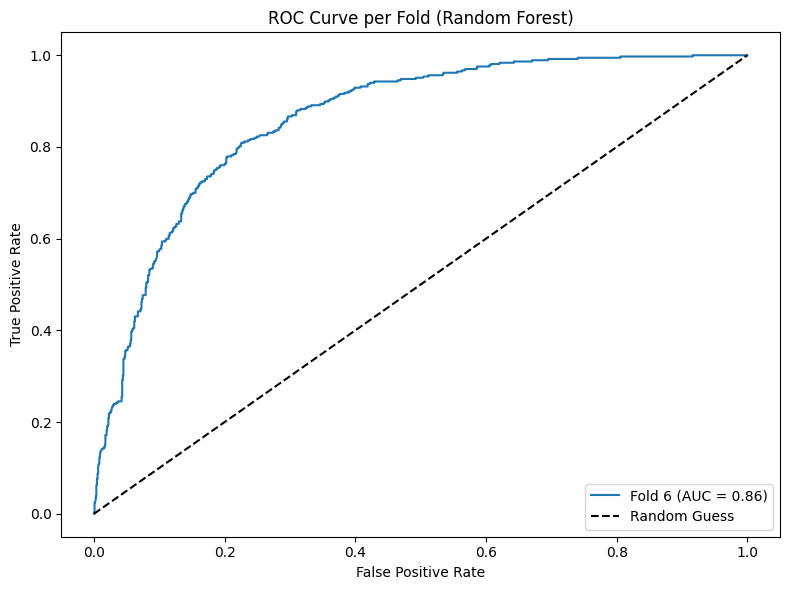


Average AUC across folds (Random Forest): 0.8614


In [34]:
auc_scores_rf = []
y_proba_rf = rf_model.predict_proba(X_test_fold)[:, 1]
auc_rf = roc_auc_score(y_test_fold, y_proba_rf)
auc_scores_rf.append(auc_rf)
fpr, tpr, _ = roc_curve(y_test_fold, y_proba_rf)

#Gráfica
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Fold (Random Forest)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# AUC promedio
print(f"\nAverage AUC across folds (Random Forest): {np.mean(auc_scores_rf):.4f}")

##Duración de contrato x Cancelación

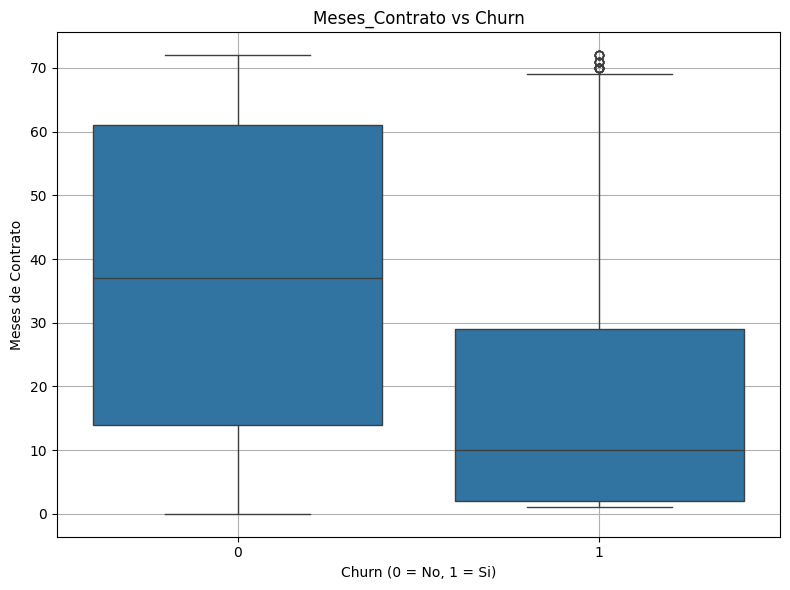

In [40]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=Df_final, x='Churn', y='Meses_Contrato')
plt.title('Meses_Contrato vs Churn')
plt.xlabel('Churn (0 = No, 1 = Si)')
plt.ylabel('Meses de Contrato')
plt.grid(True)
plt.tight_layout()
plt.show()

## Total Facturado x Cancelación (Churn)

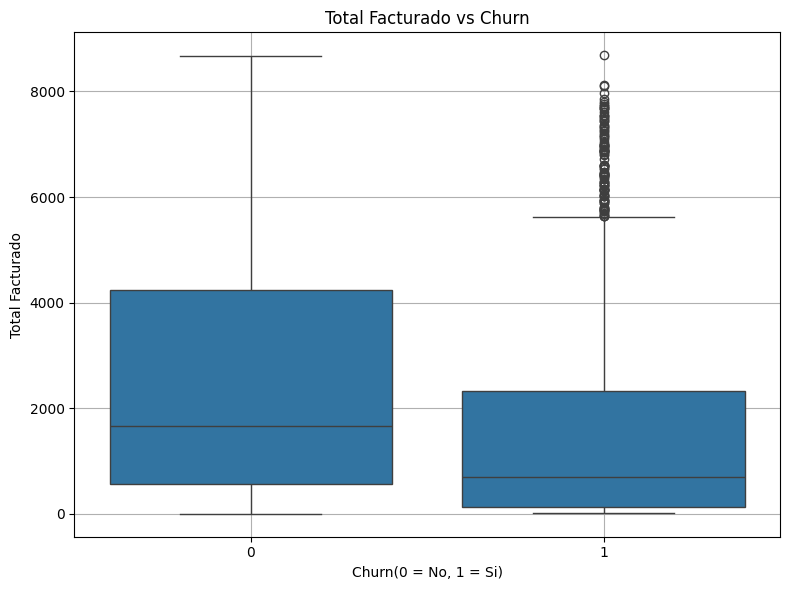

In [41]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=Df_final, x='Churn', y='Total_Facturado')
plt.title('Total Facturado vs Churn')
plt.xlabel('Churn(0 = No, 1 = Si)')
plt.ylabel('Total Facturado')
plt.grid(True)
plt.tight_layout()
plt.show()